In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import math as mt
from tensorflow import keras
from tensorflow.keras import layers
import time
import wandb
import julia
import os
from julia import DynamicalSystems
from julia import Base
from julia import Main
from julia import DifferentialEquations
from matplotlib import rc
%load_ext julia.magic

physical_devices = tf.config.list_physical_devices("GPU")
tf.config.experimental.set_memory_growth(physical_devices[0], True)

Initializing Julia interpreter. This may take some time...


In [2]:
%julia Hx(x,y,t) = 0.25*sin(x) - 0.5*(0.3*y*sin(2*t) + 0.7*y*sin(3*t))
%julia Hy(x,y,t) = y - 0.5*(0.3*x*sin(2*t) + 0.7*x*sin(3*t))
%julia function HamiltonianSystem!(du,u,p,t);     du[1] = -Hy(u[1], u[2], t);    du[2] = Hx(u[1], u[2], t); end

%julia Npoints = 100000
%julia r = 1.
%julia u0 = []

#Asymmetric dataset
#%julia while length(u0)<Npoints; x = 0.001*rand(0:800)*rand((-1,1)); y = 0.001*rand(0:800); if x*x + y*y < r*r; push!(u0,[x, y]); end; end
#Validation set an the end
#%julia while length(u0)< Npoints+10000; x = 0.001*rand(0:800)*rand((-1,1)); y = 0.001*rand(0:800)*rand((-1,1)); if x*x + y*y < r*r; push!(u0,[x, y]); end; end



%julia while length(u0)<Npoints; x = 0.001*rand(0:1000)*rand((-1,1)); y = 0.001*rand(0:1000)*rand((-1,1)); if x*x + y*y < r*r; push!(u0,[x, y]); end; end

#%julia Npoints = Npoints + 40000
#%julia r = 0.4
#%julia while length(u0)<Npoints; x = 0.001*rand(0:400)*rand((-1,1)); y = 0.001*rand(0:400)*rand((-1,1)); if x*x + y*y < r*r; push!(u0,[x, y]); end; end

In [3]:
start_time = time.time()

%julia tspan = (0.0, 2*π)
%julia saveat = 0.003

%julia T = []

%julia for k in u0; prob = DifferentialEquations.ODEProblem(HamiltonianSystem!, k, tspan); sol = DifferentialEquations.solve(prob, DifferentialEquations.Vern7(), saveat=saveat);  push!(T, sol.u[end]); end

# SHUFFLE
#%julia shuffle!(rng, vector)


u0 = Main.u0
T = Main.T

print("running time : %s seconds" % (time.time() - start_time))

running time : 65.7570972442627 seconds


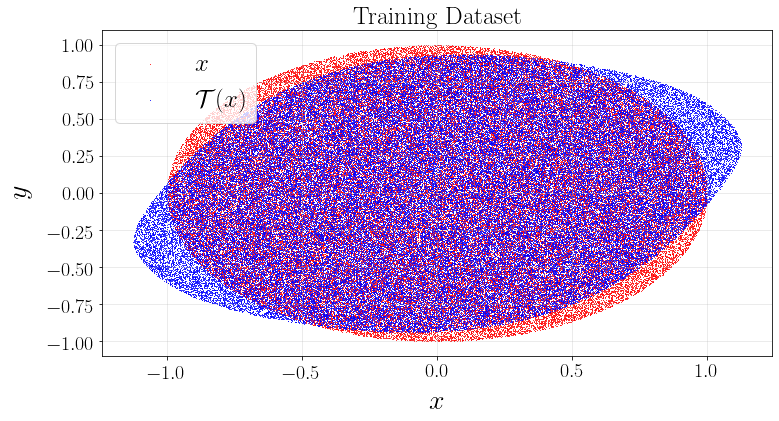

In [9]:
plt.figure(figsize=(12,6))
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.title(r'Training Dataset', fontsize = 25)
plt.scatter([u0[i][0] for i in range(len(u0))], [u0[i][1] for i in range(len(u0))], label = r'$x$', linewidth = 0, color ='r', s=1)
plt.scatter([T[i][0] for i in range(len(u0))], [T[i][1] for i in range(len(u0))], label = r'$\mathcal{T}(x)$', linewidth = 0, color = 'b', s=1)
plt.xlabel(r'$x$', fontsize=28, labelpad=8)
plt.ylabel(r'$y$', fontsize=28, labelpad=15)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid(axis='both', alpha=.3)
plt.legend(fontsize = 25)
#plt.xlim(0.1,0.8)
#plt.ylim(-0.9,0.9)
#plt.savefig("DoublePendulum_Example")
plt.show()

In [7]:
os.remove("x_train.txt")

f = open("x_train.txt", "a")
for i in u0:
    f.write(str(i[0]))
    f.write("\n")
    f.write(str(i[1]))
    f.write("\n")
f.close()

In [8]:
os.remove("y_train.txt")

f = open("y_train.txt", "a")
for i in T:
    f.write(str(i[0]))
    f.write("\n")
    f.write(str(i[1]))
    f.write("\n")
f.close()

### Poincare Plot

In [10]:
%julia Hx(x,y,t) = 0.25*sin(x) - 0.5*(0.3*y*sin(2*t) + 0.7*y*sin(3*t))
%julia Hy(x,y,t) = y - 0.5*(0.3*x*sin(2*t) + 0.7*x*sin(3*t))
%julia function HamiltonianSystem!(du,u,p,t);     du[1] = -Hy(u[1], u[2], t);    du[2] = Hx(u[1], u[2], t); end


%julia u0 = [[0.0, 0.1],[0.0, 0.2],[0.0, 0.3],[0.0, 0.4],[0.0, 0.5],[0.0, 0.6],[0.1, 0.],[0.2, 0.],[0.3, 0.],[0.4, 0.],[0.5, 0.]]
#%julia u0 = [[rand(-400:400)*0.001, rand(-400:400)*0.001] for i in 1:100]
#%julia for i in 0:3 push!(u0,[0.0, 0.1 + 0.1*i]); end
#%julia for i in 0:6 push!(u0,[0.1*i + 0.1, 0.0]); end


%julia tspan = (0.0, 1000*2*π)
%julia saveat = 0.001*2*π

%julia T = []
%julia N_iter = 1000
%julia for k in u0; prob = DifferentialEquations.ODEProblem(HamiltonianSystem!, k, tspan); sol = DifferentialEquations.solve(prob, DifferentialEquations.Vern7(), saveat=saveat); for i in 1:N_iter; push!(T, sol.u[1000*i]); end; end

u0 = Main.u0
T = Main.T

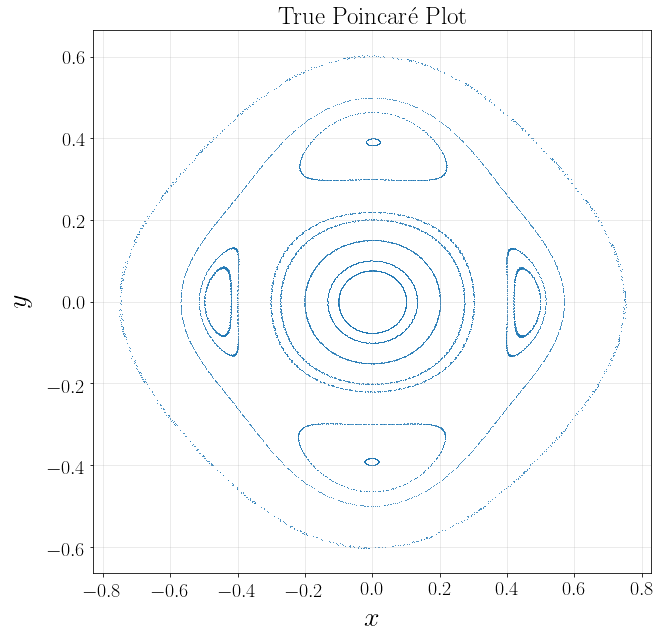

In [11]:
plt.figure(figsize=(10,10))
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.title(r'True Poincar\'e Plot', fontsize = 25)
plt.scatter([T[i][0] for i in range(len(T))], [T[i][1] for i in range(len(T))], s=1, linewidth=0)

#plt.scatter([u0[i][0] for i in range(len(u0))], [u0[i][1] for i in range(len(u0))], s=13, color='r')

#plt.scatter([0.0 for i in range(8)], [0.08*i for i in range(8)], s=13, color='r')
#plt.scatter([(0.2 + 0.08*i) for i in range(5)], [0.0 for i in range(5)], s=13, color='r')
plt.xlabel(r'$x$', fontsize=28, labelpad=8)
plt.ylabel(r'$y$', fontsize=28, labelpad=15)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid(axis='both', alpha=.3)
#plt.savefig("True_Poincare_Plot")
plt.show()

In [13]:
os.remove("Poincare.txt")

f = open("Poincare.txt", "a")
for i in T:
    f.write(str(i[0]))
    f.write("\n")
    f.write(str(i[1]))
    f.write("\n")
f.close()

## 2 Iterations

In [11]:
%julia Hx(x,y,t) = 0.25*sin(x) - 0.5*(0.3*y*sin(2*t) + 0.7*y*sin(3*t))
%julia Hy(x,y,t) = y - 0.5*(0.3*x*sin(2*t) + 0.7*x*sin(3*t))
%julia function HamiltonianSystem!(du,u,p,t);     du[1] = -Hy(u[1], u[2], t);    du[2] = Hx(u[1], u[2], t); end

%julia Npoints = 100000
%julia r = 1.5
%julia u0 = []
%julia while length(u0)<Npoints; x = 0.001*rand(0:1500)*rand((-1,1)); y = 0.001*rand(0:1500)*rand((-1,1)); if x*x + y*y < r*r; push!(u0,[x, y]); end; end

#%julia Npoints = 12000
#%julia r = 1.5
#%julia while length(u0)<Npoints; x = 0.001*rand(0:1500)*rand((-1,1)); y = 0.001*rand(0:1500)*rand((-1,1)); if x*x + y*y < r*r; push!(u0,[x, y]); end; end


%julia tspan = (0.0, 4*π)
%julia saveat = 0.003

%julia T = []

%julia for k in u0; prob = DifferentialEquations.ODEProblem(HamiltonianSystem!, k, tspan); sol = DifferentialEquations.solve(prob, DifferentialEquations.Vern7(), saveat=saveat);  push!(T, sol.u[end]); end



u0 = Main.u0
T = Main.T

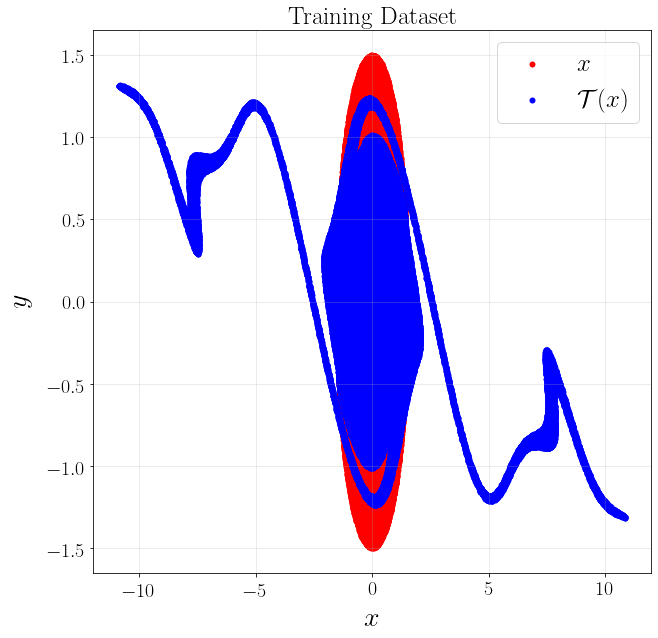

In [12]:
plt.figure(figsize=(10,10))
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.title(r'Training Dataset', fontsize = 25)
plt.scatter([u0[i][0] for i in range(len(u0))], [u0[i][1] for i in range(len(u0))], label = r'$x$', linewidth = 0, color ='r')
plt.scatter([T[i][0] for i in range(len(u0))], [T[i][1] for i in range(len(u0))], label = r'$\mathcal{T}(x)$', linewidth = 0, color = 'b')
plt.xlabel(r'$x$', fontsize=28, labelpad=8)
plt.ylabel(r'$y$', fontsize=28, labelpad=15)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid(axis='both', alpha=.3)
plt.legend(fontsize = 25)
#plt.savefig("DoublePendulum_Example")
plt.show()

In [13]:
#os.remove("x_train_PPH_2iter.txt")

f = open("x_train_PPH_2iter.txt", "a")
for i in u0:
    f.write(str(i[0]))
    f.write("\n")
    f.write(str(i[1]))
    f.write("\n")
f.close()

In [14]:
#os.remove("y_train_PPH_2iter.txt")

f = open("y_train_PPH_2iter.txt", "a")
for i in T:
    f.write(str(i[0]))
    f.write("\n")
    f.write(str(i[1]))
    f.write("\n")
f.close()